# Real-Time American Sign Language Detection and Speech Synthesis

This notebook implements a real-time Word-Level American Sign Language detection system with speech output. The system will:

1. Capture video input from the webcam
2. Detect hand gestures and classify them as ASL signs
3. Convert recognized signs to text
4. Synthesize speech from the recognized text

This implementation uses a modular approach with code organized into the following modules:

- `mediapipe_utils.py`: MediaPipe detection and landmark utilities
- `data_processing.py`: Dataset creation and handling
- `model_utils.py`: Model training and evaluation
- `realtime_asl.py`: Real-time detection functionality
- `sign_model_builder.py`: LSTM model architecture

Let's get started by installing the necessary dependencies.

In [ ]:
# Install required packages if they are not already installed
!pip install opencv-python mediapipe torch torchvision numpy pyttsx3 matplotlib tqdm

## Import Libraries

We'll import the necessary libraries and modules for our application.

In [ ]:

import mediapipe as mp
import os
import pyttsx3
import torch
from module.helper_functions import plot_loss_curves

# Import our modular components
import sys
sys.path.append('./module')
from module.mediapipe_utils import setup_holistic_model
from module.data_processing import collect_sign_data, organize_data_for_testing, create_separate_dataloaders
from module.model_utils import train, save_model
from module.realtime_asl import ASLDetector
from module.sign_model_builder import LSTM_Sign_Model

# Initialize MediaPipe solutions (for backward compatibility with existing code)
mp_holistic = mp.solutions.holistic

## MediaPipe Setup

We're using the modular implementation from `mediapipe_utils.py` for hand tracking and landmark detection.

In [17]:
# Initialize MediaPipe solutions for visualization if needed
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

# We're using the modular implementation for these functions:
# - mediapipe_detection from module.mediapipe_utils
# - draw_landmarks from module.mediapipe_utils
# - extract_keypoints from module.mediapipe_utils
# - setup_holistic_model from module.mediapipe_utils

## Keypoint Extraction

We're using the keypoint extraction functionality from our `module.mediapipe_utils` module, which extracts useful data from MediaPipe detections for our model.

In [4]:
# Using extract_keypoints from module.mediapipe_utils, which:
# 1. Extracts pose landmarks (33 points with x, y, z, visibility)
# 2. Extracts face landmarks (468 points with x, y, z)
# 3. Extracts left hand landmarks (21 points with x, y, z) 
# 4. Extracts right hand landmarks (21 points with x, y, z)
# 5. Concatenates all points into a single feature vector

# This gives us a feature vector of length 1662:

## Explore the Dataset

Let's explore the available data to understand what we're working with.

In [18]:
# List the available signs in our dataset
data_path = os.path.join('data')
actions = os.listdir(data_path)
# Remove any hidden files (like .DS_Store)
actions = [action for action in actions if not action.startswith('.')]

print(f"Available signs: {actions}")

# Get some stats about the dataset
sign_folders = os.listdir(os.path.join(data_path, actions[0]))
num_sequences = len(sign_folders)
sequence_length = len(os.listdir(os.path.join(data_path, actions[0], '0')))

print(f"Number of sequences per sign: {num_sequences}")
print(f"Frames per sequence: {sequence_length}")

Available signs: ['thanks', 'hello', 'whatsup', 'iloveyou']
Number of sequences per sign: 30
Frames per sequence: 3


## Load or Build the PyTorch Model

We'll either load a pre-trained model from disk or build a new PyTorch model for sign language detection.

In [5]:
# # Check if we have a pre-trained model
# try:
#     model = torch.load('model/sign_language_model.pth')
#     print("Loaded pre-trained model from disk.")
    
#     # Get the list of actions from the saved model
#     data_path = os.path.join('data')
#     actions = os.listdir(data_path)
#     # Remove any hidden files (like .DS_Store)
#     actions = [action for action in actions if not action.startswith('.')]
    
# except:
#     print("Building a new model...")
    
#     # List the available signs in our dataset
#     data_path = os.path.join('data')
#     actions = os.listdir(data_path)
#     # Remove any hidden files (like .DS_Store)
#     actions = [action for action in actions if not action.startswith('.')]
    
#     # Define model parameters
#     input_size = 1662  # Number of features in keypoints
#     hidden_size = 64
#     num_layers = 1
#     num_classes = len(actions)
    
#     # Initialize model using our modular approach
#     model = LSTM_Sign_Model(
#         input_size=input_size, 
#         hidden_size=hidden_size, 
#         num_layers=num_layers, 
#         num_classes=num_classes
#     )
    
#     # Create a directory for saving the model if it doesn't exist
#     os.makedirs('model', exist_ok=True)
    
# If CUDA is available, move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

print(f"Model is using device: {device}")

Model is using device: cpu


## Set Up Text-to-Speech Engine

We'll use pyttsx3 for speech synthesis to convert detected signs to spoken words.

In [10]:
# Initialize the text-to-speech engine
engine = pyttsx3.init()

def speak(text):
    """Convert text to speech."""
    engine.say(text)
    engine.runAndWait()

## Real-Time Detection with PyTorch

Now, let's implement the real-time detection using our PyTorch model and the modular ASLDetector class.

In [20]:
# Create a detector instance using our modular implementation
detector = ASLDetector(model_path='model/sign_language_model.pth', 
                      threshold=0.7,
                      sequence_length=30, 
                      device=device)

# Start real-time detection
detector.detect_in_realtime(camera_idx=0)

NameError: name 'ASLDetector' is not defined

## Data Collection Function

We'll use the modular function from `module.data_processing` to collect sign language data. This will help us build a custom dataset with our own gestures.

In [29]:
# Note: We're using the modular implementation from module.data_processing
# collect_sign_data(sign_name, holistic_model, num_sequences=30, sequence_length=30, camera_idx=0)

## Use the Data Collection Function

Run the cell below to collect data for a new sign. Follow these steps:
1. Enter the name of the sign you want to collect data for (e.g., 'thankyou', 'yes', 'no')
2. When the webcam starts, position yourself in front of the camera
3. After the 5-second countdown, perform the sign at a natural pace
4. Repeat for all sequences (default: 30)

To ensure good data quality:
- Maintain good lighting
- Keep a consistent background
- Try to perform the sign consistently each time
- Vary your position slightly between sequences for better model generalization

In [23]:
# Run this cell to collect data for a new sign
new_sign = input("Enter the name of the sign you want to collect data for: ")
num_seq = int(input("Enter the number of sequences to collect (default: 30): ") or 30)
seq_length = int(input("Enter the number of frames per sequence (default: 30): ") or 30)

print(f"\nPreparing to collect data for sign: '{new_sign}'")
print("Position yourself in front of the camera.")
print("Press Enter to start...")
input()

# Create holistic model for data collection
with setup_holistic_model() as holistic:
    collect_sign_data(new_sign, holistic, num_seq, seq_length)

# Update the actions list
if os.path.exists('data'):
    actions = [action for action in os.listdir('data') if not action.startswith('.')]
    print(f"Updated available signs: {actions}")


Preparing to collect data for sign: 'man'
Position yourself in front of the camera.
Press Enter to start...


I0000 00:00:1744794392.282842 2056574 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M1
W0000 00:00:1744794392.392479 2265535 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744794392.412116 2265536 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744794392.418453 2265538 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744794392.420651 2265539 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744794392.422387 2265533 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support 

KeyboardInterrupt: 

## Train with Separate Training and Testing Data

If you have separate datasets for training and testing, you can use the following function to train your model using both datasets.

In [14]:
# Run this cell to organize your data

organize_data_for_testing(train_split=0.7)

Data organized into data_train and data_test directories
Training data: 70%, Testing data: 30%


In [12]:
# Run this cell to train with separate train and test datasets using our modular function

# First, organize your data for testing if not already done
# organize_data_for_testing(train_split=0.7)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


train_dir = "data_train"
test_dir = "data_test"

NUM_EPOCHS = 5
BATCH_SIZE = 32
HIDDEN_UNITS = 10
LEARNING_RATE = 0.001
INPUT_SIZE = 1662

if not (os.path.exists(train_dir) and os.path.exists(test_dir)):
    print(f"end=point: {train_dir} or {test_dir} does not exist.")
    print(f"Please run the data organization cell first.")
    organize_data_for_testing(train_split=0.7)


train_dataloader, test_dataloader, class_names = create_separate_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    batch_size=BATCH_SIZE,
)

print(f"Created dataloaders with {len(class_names)} classes: {class_names}")
print(f"Train dataset size: {len(train_dataloader.dataset)} samples")
print(f"Test dataset size: {len(test_dataloader.dataset)} samples")




            
# Initialize model using our modular structure
model = LSTM_Sign_Model(
    input_size=INPUT_SIZE, 
    hidden_size=HIDDEN_UNITS,
    num_layers=NUM_EPOCHS,
    num_classes=len(class_names) 
)
        
    
# Make sure model is on the right device
model.to(device)

# Update the global actions variable for real-time detection
actions = class_names

# Set loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Train the model using our modular function

train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=criterion,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    device=device
)
# Save the model
save_model(
    model=model,
    model_path='model/sign_language_model.pth',
    actions=actions
)

Created dataloaders with 5 classes: ['man', 'thanks', 'hello', 'whatsup', 'iloveyou']
Train dataset size: 95 samples
Test dataset size: 65 samples


  0%|          | 0/5 [00:00<?, ?it/s]


ValueError: need at least one array to stack

## Check Dataloaders and Fix Training Function

Let's check if there's an issue with our dataloaders and fix the parameter mismatch in the train function call.

In [27]:
import sys
sys.path.append('./module')
from module.mediapipe_utils import setup_holistic_model
from module.data_processing import collect_sign_data, organize_data_for_testing, create_separate_dataloaders
from module.model_utils import train, save_model, plot_loss_curves
from module.realtime_asl import ASLDetector
from module.sign_model_builder import LSTM_Sign_Model
organize_data_for_testing(train_split=0.7)

Data organized into data_train and data_test directories
Training data: 70%, Testing data: 30%


## Fix Dataset Class for Consistent Sequence Lengths

Let's fix the issue with the dataset class to ensure all sequences have the same length.

In [21]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
import os

class FixedSignLanguageDataset(Dataset):
    """PyTorch Dataset for Sign Language folder structure with fixed-length sequences."""
    
    def __init__(self, data_dir, target_frames=30):
        self.data_dir = data_dir
        self.target_frames = target_frames  # Target number of frames per sequence
        self.classes = [cls for cls in os.listdir(data_dir) if not cls.startswith('.')]
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        
        # Find all sequences
        self.sequences = []
        self.labels = []
        
        for cls in self.classes:
            cls_dir = os.path.join(data_dir, cls)
            for seq_id in os.listdir(cls_dir):
                if not seq_id.startswith('.') and os.path.isdir(os.path.join(cls_dir, seq_id)):
                    seq_path = os.path.join(cls_dir, seq_id)
                    # Check if directory has at least one .npy file before adding
                    npy_files = [f for f in os.listdir(seq_path) if f.endswith('.npy')]
                    if len(npy_files) > 0:
                        self.sequences.append(seq_path)
                        self.labels.append(self.class_to_idx[cls])
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq_path = self.sequences[idx]
        label = self.labels[idx]
        
        # Load all frames in sequence
        frames = []
        frame_files = sorted([f for f in os.listdir(seq_path) if f.endswith('.npy')],
                             key=lambda x: int(x.split('.')[0]))
        
        for frame_file in frame_files:
            frame_path = os.path.join(seq_path, frame_file)
            try:
                frame = np.load(frame_path)
                frames.append(frame)
            except Exception as e:
                print(f"Error loading {frame_path}: {e}")
                continue
                
        # Ensure we have the right number of frames with proper handling
        if len(frames) == 0:
            # No valid frames, return zeros with the right shape
            return torch.zeros((self.target_frames, 1662), dtype=torch.float32), torch.tensor(label, dtype=torch.long)
        
        # Check that all frames have the same shape
        shapes = [frame.shape[0] for frame in frames]
        if len(set(shapes)) > 1:
            # If frames have different shapes, use only those with the most common shape
            common_shape = max(set(shapes), key=shapes.count)
            frames = [frame for frame in frames if frame.shape[0] == common_shape]
            
        # Handle sequences with different lengths
        if len(frames) < self.target_frames:
            # Pad short sequences by repeating the last frame
            if len(frames) > 0:
                last_frame = frames[-1]
                padding = [last_frame] * (self.target_frames - len(frames))
                frames.extend(padding)
            else:
                # No frames, generate empty ones
                return torch.zeros((self.target_frames, 1662), dtype=torch.float32), torch.tensor(label, dtype=torch.long)
        elif len(frames) > self.target_frames:
            # Truncate long sequences
            frames = frames[:self.target_frames]
        
        # Stack frames into a single array
        sequence = np.stack(frames)
        
        return torch.tensor(sequence, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Create custom function to create dataloaders with the fixed dataset class
def create_fixed_dataloaders(train_dir, test_dir, batch_size=32, num_workers=0):
    """Create separate training and testing dataloaders with fixed sequence lengths."""
    # Create datasets using our fixed dataset class
    train_dataset = FixedSignLanguageDataset(train_dir)
    test_dataset = FixedSignLanguageDataset(test_dir)
    
    # Create dataloaders
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    
    test_dataloader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )
    
    return train_dataloader, test_dataloader, train_dataset.classes

In [22]:
# Create new dataloaders with our fixed implementation
train_dir = "data_train"
test_dir = "data_test"
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = create_fixed_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    batch_size=BATCH_SIZE,
)

# Check if dataloaders are empty or have issues
print(f"Train dataloader length: {len(train_dataloader)}")
print(f"Test dataloader length: {len(test_dataloader)}")

# Check first batch in each dataloader
for batch_idx, (data, target) in enumerate(train_dataloader):
    print(f"Train batch {batch_idx}: data shape = {data.shape}, target shape = {target.shape}")
    break  # Just check the first batch
    
for batch_idx, (data, target) in enumerate(test_dataloader):
    print(f"Test batch {batch_idx}: data shape = {data.shape}, target shape = {target.shape}")
    break  # Just check the first batch
    
# Update the model for the correct number of classes
NUM_EPOCHS = 5
HIDDEN_UNITS = 10
LEARNING_RATE = 0.001
INPUT_SIZE = 1662

# Initialize model using our modular structure
model = LSTM_Sign_Model(
    input_size=INPUT_SIZE, 
    hidden_size=HIDDEN_UNITS,
    num_layers=1,  # Setting num_layers to 1 instead of NUM_EPOCHS which was incorrect
    num_classes=len(class_names) 
)
        
# Make sure model is on the right device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

Train dataloader length: 3
Test dataloader length: 3
Train batch 0: data shape = torch.Size([32, 30, 1662]), target shape = torch.Size([32])
Test batch 0: data shape = torch.Size([32, 30, 1662]), target shape = torch.Size([32])


 40%|████      | 2/5 [00:00<00:00,  4.12it/s]

Epoch: 1 | train_loss: 1.2665 | train_acc: 0.3690 | test_loss: 1.2808 | test_acc: 0.2812
Epoch: 2 | train_loss: 1.2517 | train_acc: 0.3696 | test_loss: 1.2727 | test_acc: 0.2708


 80%|████████  | 4/5 [00:00<00:00,  5.73it/s]

Epoch: 3 | train_loss: 1.2588 | train_acc: 0.3152 | test_loss: 1.2651 | test_acc: 0.4792
Epoch: 4 | train_loss: 1.2579 | train_acc: 0.3464 | test_loss: 1.2553 | test_acc: 0.4792


100%|██████████| 5/5 [00:00<00:00,  5.22it/s]



Epoch: 5 | train_loss: 1.2496 | train_acc: 0.3474 | test_loss: 1.2456 | test_acc: 0.4792
Model saved as 'model/sign_language_model.pth'


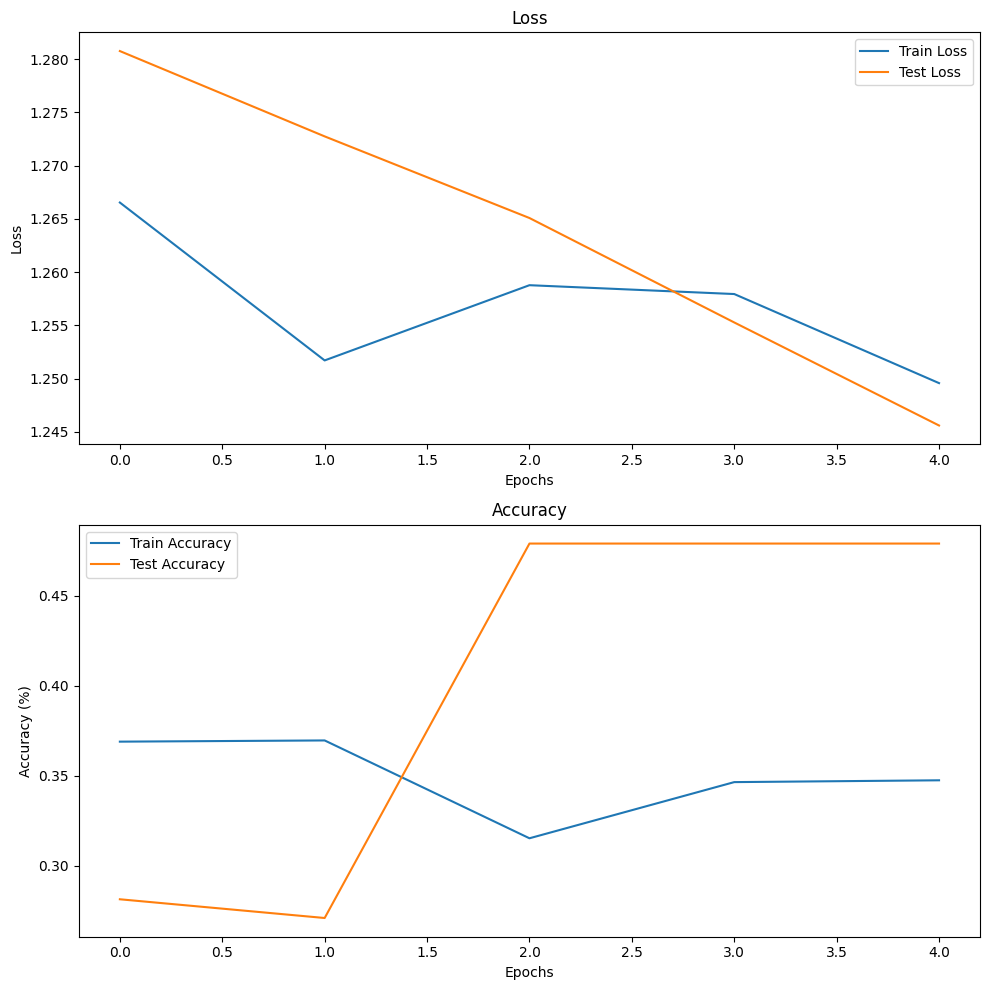

In [29]:
# Train the model with the corrected function call
results = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=criterion,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    device=device
) 

# Save the model
save_model(
    model=model,
    path='model/sign_language_model.pth',
)


# Plot loss curves
plot_loss_curves(results)


## Visualize Training Results

Let's visualize the training and testing results to evaluate our model's performance.

In [ ]:
# Plot loss curves from the training results
try:
    from module.helper_functions import plot_loss_curves
    plot_loss_curves(results)
except Exception as e:
    print(f"Error plotting loss curves: {e}")
    
    # Alternative plotting method if helper function fails
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(results['train_loss'], label='Train Loss')
    plt.plot(results['test_loss'], label='Test Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(results['train_acc'], label='Train Accuracy')
    plt.plot(results['test_acc'], label='Test Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

## Future Improvements

Here are some potential improvements for the application:

1. **Sentence Formation**: Implement grammar rules to form proper sentences from detected signs.
2. **Continuous Sign Language Recognition**: Improve the model to handle continuous signing.
3. **User Interface**: Create a more user-friendly interface with settings for sensitivity and speech voice.
4. **Mobile Application**: Convert the system to a mobile application for wider accessibility.
5. **Expanded Vocabulary**: Train the model on a larger dataset to recognize more signs.
6. **Two-Way Translation**: Add speech-to-sign functionality for two-way communication.

## Conclusion

This notebook demonstrates a real-time American Sign Language detection and speech synthesis system. The application uses:

1. MediaPipe for hand tracking and landmark detection
2. PyTorch for sign classification using an LSTM model
3. OpenCV for video capture and visualization
4. pyttsx3 for text-to-speech conversion

The system can detect Word-Level ASL signs and convert them to speech in real-time, providing a valuable tool for sign language communication.